In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.path import Path
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from random import choice

import py4DSTEM

In [4]:
#fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

## Slice up diffraction space

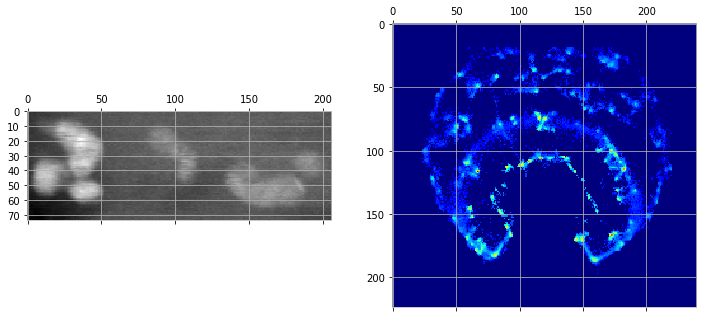

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

In [6]:
Q_Nx,Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

#### Classify diffraction space
w/ a Voronoi diagram about average deconvolution maxima

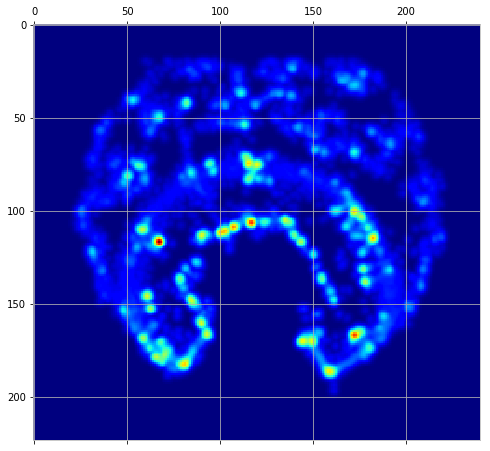

In [7]:
# Make smoothed deconvolution

sigma=1
deconvolution_smoothed = gaussian_filter(deconvolution,sigma)

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(deconvolution_smoothed**0.25,cmap='jet')
plt.show()

In [8]:
# Get maxima

maxima = py4DSTEM.process.utils.get_maximal_points(deconvolution_smoothed)
max_point_indices_x, max_point_indices_y = np.nonzero(maxima)
point_intensities = deconvolution_smoothed[max_point_indices_x,max_point_indices_y]

coords = [('qx',float),('qy',float),('intensity',float)]
deconvolution_peaks = py4DSTEM.file.datastructure.PointList(coordinates=coords)
length = len(point_intensities)
for i in range(length):
    new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
    deconvolution_peaks.add_point(new_point)

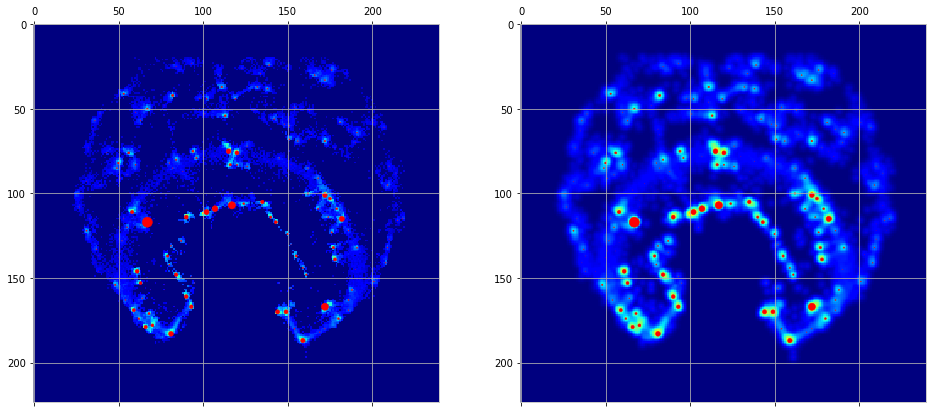

In [9]:
# Show
scale=100

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax1.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r',
            s=scale*deconvolution_peaks.data['intensity']/np.max(deconvolution_peaks.data['intensity']))
ax2.matshow(deconvolution_smoothed**0.25,cmap='jet')
ax2.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r',
            s=scale*deconvolution_peaks.data['intensity']/np.max(deconvolution_peaks.data['intensity']))
plt.show()

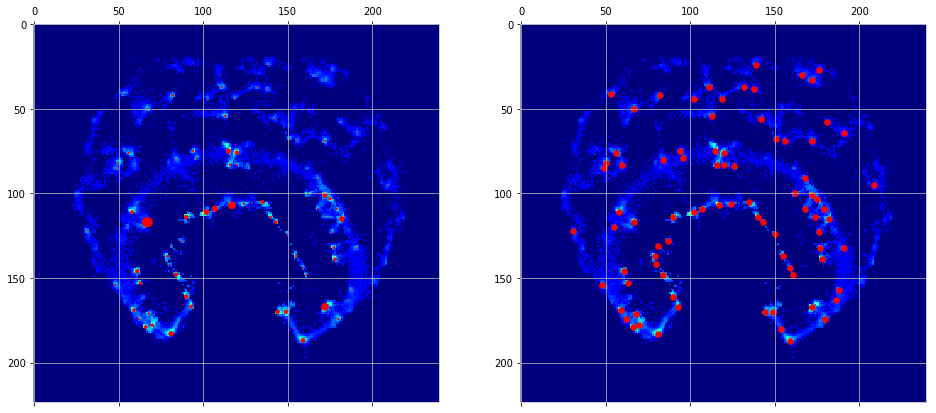

In [10]:
# Threshold average deconvolution maxima

minRelIntensity = 0.005
scale=100

deconvolution_peaks_thresh = deconvolution_peaks.copy()
deletemask = np.zeros(deconvolution_peaks_thresh.length, dtype=bool)
deletemask = deconvolution_peaks_thresh.data['intensity']/np.max(deconvolution_peaks_thresh.data['intensity']) < minRelIntensity
deconvolution_peaks_thresh.remove_points(deletemask)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax1.scatter(deconvolution_peaks_thresh.data['qy'],deconvolution_peaks_thresh.data['qx'],color='r',
            s=scale*deconvolution_peaks_thresh.data['intensity']/np.max(deconvolution_peaks_thresh.data['intensity']))
ax2.matshow(deconvolution**0.25,cmap='jet')
ax2.scatter(deconvolution_peaks_thresh.data['qy'],deconvolution_peaks_thresh.data['qx'],color='r')
plt.show()

In [11]:
# Make a Voronoi diagram

deconvolution_peaks_thresh.sort('intensity')
points = np.vstack((deconvolution_peaks_thresh.data['qx'],deconvolution_peaks_thresh.data['qy'])).T

voronoi = Voronoi(points)#, qhull_options='Qz QJ')

In [12]:
# Let's see if we can make a mask for each Voronoi region...

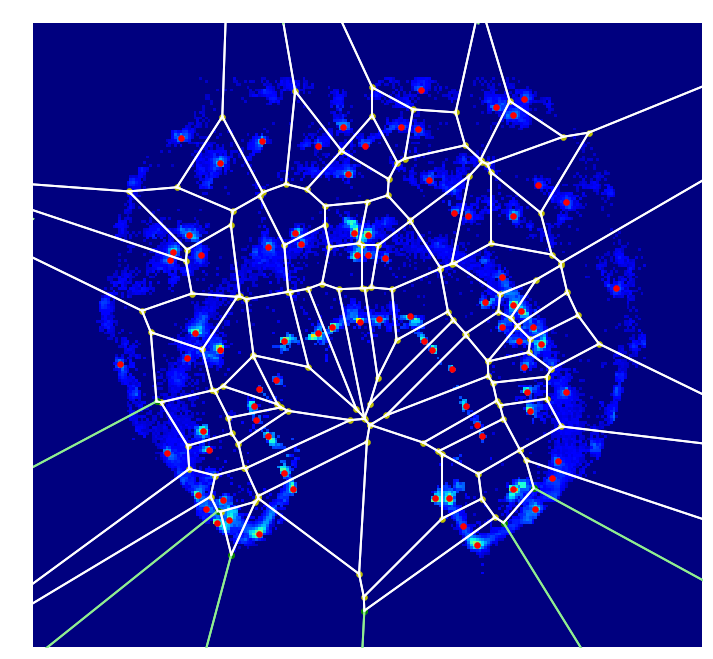

In [13]:
# Show the Voronoi diagram laid over the deconvolution

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')

# For each ridge extending out of the frame, get:
#   -the indices of of its vertices, in voronoi.vertices, and
#   -the indices of its regions (class labels) in voronoi.point_region
edgeridge_vertices_and_points = []
for i in range(len(voronoi.ridge_vertices)):
    ridge = voronoi.ridge_vertices[i]
    if -1 in ridge:
        edgeridge_vertices_and_points.append([min(ridge),max(ridge),
                                              voronoi.ridge_points[i,0],
                                              voronoi.ridge_points[i,1]])
edgeridge_vertices_and_points = np.array(edgeridge_vertices_and_points)
center = voronoi.points.mean(axis=0)
for region in voronoi.point_region:
    vor_vertex_indices = voronoi.regions[region]
    for i in range(len(vor_vertex_indices)):
        index0 = vor_vertex_indices[i]
        index1 = vor_vertex_indices[(i+1)%len(vor_vertex_indices)]
        if index0!=-1 and index1!=-1:
            x0,y0 = voronoi.vertices[index0]
            x1,y1 = voronoi.vertices[index1]
            ax.plot((y0,y1),(x0,x1),'w')
        else:
            # We need to define a point far away to connect to
            near_ind, far_ind = max(index0,index1),min(index0,index1) # identify which is -1
            x,y = voronoi.vertices[near_ind]
            ax.scatter(y,x,color='g')
            
            # Find new edge point
            edgeridge_index = int(np.argwhere(edgeridge_vertices_and_points[:,1]==near_ind))
            _,_,point0,point1 = edgeridge_vertices_and_points[edgeridge_index,:]
            x_p0,y_p0 = voronoi.points[point0]   
            x_p1,y_p1 = voronoi.points[point1]   # The positions of the voronoi points this ridge divides
            x_v,y_v = voronoi.vertices[near_ind]
            m = -(x_p1-x_p0)/(y_p1-y_p0)
            b = y_v - x_v*m
            y_line = lambda x: m*x+b
            x_line = lambda y: (y-b)/m
            x_edges,y_edges = np.zeros(4),np.zeros(4)
            x_edges[0],y_edges[0] = 0, y_line(0)
            x_edges[1],y_edges[1] = Q_Nx, y_line(Q_Nx)
            x_edges[2],y_edges[2] = x_line(0), 0
            x_edges[3],y_edges[3] = x_line(Q_Ny), Q_Ny
            i_edge = np.argmin(np.hypot(x_edges-x_v,y_edges-y_v))
            x_edge,y_edge = x_edges[i_edge],y_edges[i_edge]
            
            ax.plot((y,y_edge),(x,x_edge),'lightgreen')
            
            

ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
ax.axis('off')
plt.gca().invert_yaxis()
plt.show()

#### Helper functions

In [14]:
def get_vertices_from_voronoi(voronoi, index, nx, ny):
    """From a Voronoi instance, return the vertices x,y of the voronoi region specified by index
    """
    assert index < voronoi.npoints, "Error: index must be < {}".format(voronoi.npoints)
    vertex_indices = voronoi.regions[index]
    
    # Handle edges
    if -1 in vertex_indices:
        vertex_indices.remove(-1)
        # Find the edge of interest, its known vertex, and the two initial voronoi points this edge divides
        for i in range(len(voronoi.ridge_vertices)):
            ridge = voronoi.ridge_vertices[i]
            if -1 in ridge:
                _,i_temp = min(ridge),max(ridge)
                if i_temp in vertex_indices:
                    x_v,y_v = voronoi.vertices[i_temp]      # x,y of known vertex to connect to edge
                    x_p0,y_p0 = voronoi.vertices[voronoi.ridge_points[i,0]]  # x,y of voronoi initial point 0
                    x_p1,y_p1 = voronoi.vertices[voronoi.ridge_points[i,1]]  # x,y of voronoi initial point 1
        # Find new edge point
        m = -(x_p1-x_p0)/(y_p1-y_p0)
        b = y_v - x_v*m
        y_line = lambda x: m*x+b
        x_line = lambda y: (y-b)/m
        x_edges,y_edges = np.zeros(4),np.zeros(4)
        x_edges[0],y_edges[0] = 0, y_line(0)
        x_edges[1],y_edges[1] = nx, y_line(nx)
        x_edges[2],y_edges[2] = x_line(0), 0
        x_edges[3],y_edges[3] = x_line(ny), ny
        i_edge = np.argmin(np.hypot(x_edges-x_v,y_edges-y_v))
        x_edge,y_edge = x_edges[i_edge],y_edges[i_edge]
        
        vertices = np.vstack((voronoi.vertices[vertex_indices],np.array([x_edge,y_edge])))
    else:
        vertices = voronoi.vertices[vertex_indices]
    
    # Handle corners
#     xmin,xmax = min(vertices[:,0]),max(vertices[:,0])
#     ymin,ymax = min(vertices[:,1]),max(vertices[:,1])
#     if xmin<=0.05 and ymin <=0.05:
#         vertices = np.vstack((vertices,np.array([0,0])))
#     elif xmin<=0.05 and ymax >= ny-0.05:
#         vertices = np.vstack((vertices,np.array([0,Q_Ny])))
#     elif xmax>=nx-0.05 and ymin <= 0.05:
#         vertices = np.vstack((vertices,np.array([Q_Nx,0])))
#     elif xmax>=nx-0.05 and ymax >= ny-0.05:
#         vertices = np.vstack((vertices,np.array([Q_Nx,Q_Ny])))
        
    return vertices

In [15]:
def polygon_mask_from_vertices(xy, nx, ny):
    """From polygon vertices x,y make a boolean mask of the polygon interior
    """
    if len(xy) < 2:
        return np.zeros((nx,ny),dtype=bool)
    poly_verts = [tuple(xy_pair) for xy_pair in xy]
    
    # Make meshgrid, and transform into stack of points
    xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
    xx, yy = xx.flatten(), yy.flatten()
    points = np.vstack((xx,yy)).T

    path = Path(poly_verts)                # Make matplotlib Path object
    mask = path.contains_points(points)    # Query if each meshgrid pnt is contained
    mask = mask.reshape((ny,nx))

    return mask.T

def get_mask_from_voronoi_index(voronoi, index, nx, ny):
    """From polygon vertices x,y and frame shape (nx,ny), added corners to vertices if appropriate
    """
    vertices = get_vertices_from_voronoi(voronoi, index, nx, ny)
    return polygon_mask_from_vertices(vertices, nx, ny)

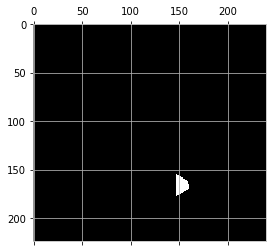

In [16]:
i = 10
mask = get_mask_from_voronoi_index(voronoi, i, Q_Nx, Q_Ny)

fig,ax=plt.subplots()
ax.matshow(mask)
plt.show()

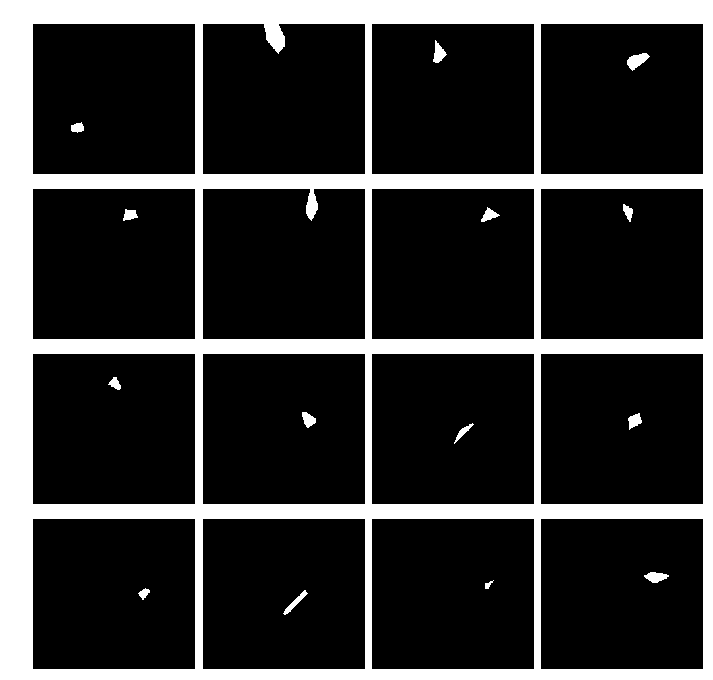

In [17]:
fig,axs = plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    ax = axs[np.unravel_index(i,(4,4))]
    mask = get_mask_from_voronoi_index(voronoi, i+50, Q_Nx, Q_Ny)
    ax.matshow(mask)
    ax.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

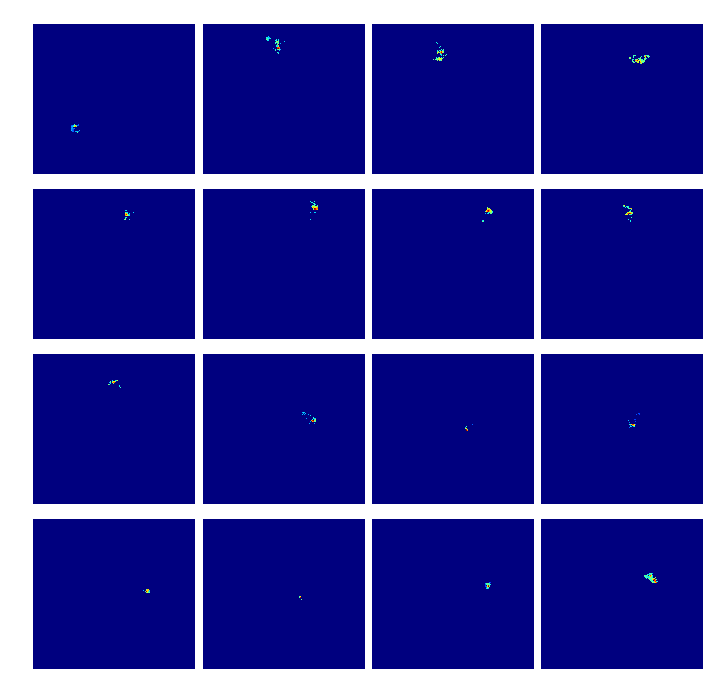

In [18]:
fig,axs = plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    ax = axs[np.unravel_index(i,(4,4))]
    mask = get_mask_from_voronoi_index(voronoi, i+50, Q_Nx, Q_Ny)
    ax.matshow(np.where(mask,deconvolution**0.2,0),cmap='jet')
    ax.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.05)

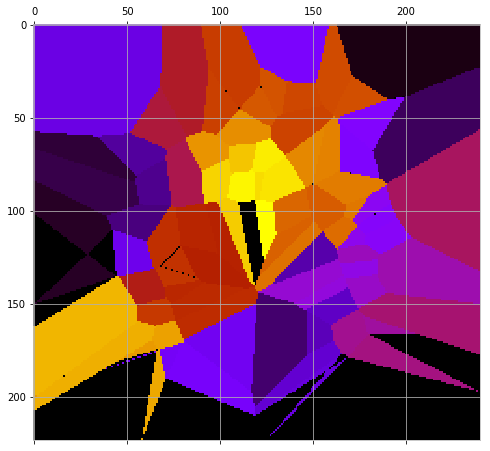

In [19]:
# Contruct array assinging a class value k to each pixel of Q-space
Q_classes = -1*np.ones((Q_Nx,Q_Ny),dtype=int)
for i in range(voronoi.npoints):
    mask = get_mask_from_voronoi_index(voronoi,i,Q_Nx,Q_Ny)
    Q_classes[mask] = i
    
# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(Q_classes,cmap='gnuplot')
plt.show()

#### Construct set of Bragg peak indices found at each scan position

In [20]:
braggpeak_sets_by_scan_position = [[set() for i in range(R_Ny)] for j in range(R_Nx)]

for Rx in range(braggpeaks.shape[0]):
    for Ry in range(braggpeaks.shape[1]):
            s = braggpeak_sets_by_scan_position[Rx][Ry]
            points = braggpeaks.get_pointlist(Rx,Ry)
            for i in range(points.length):
                qx,qy = points.data['qx'][i],points.data['qy'][i]
                qx,qy = int(np.round(qx)),int(np.round(qy))
                s.add(Q_classes[qx,qy])
            if -1 in s:
                s.remove(-1)

#### Define quantities for obtaining new region seed positions

In [21]:
def intersection(rx1,ry1,rx2,ry2):
    s1 = braggpeak_sets_by_scan_position[rx1][ry1]
    s2 = braggpeak_sets_by_scan_position[rx2][ry2]
    if len(s1)==0 or len(s2)==0:
        return -1
    return len(s1.intersection(s2))

def get_mean_NN_intersection(rx,ry):
    # Interior
    if (rx>0) and (rx<R_Nx-1) and (ry>0) and (ry<R_Ny-1):
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                        intersection(rx,ry,rx,ry-1),                                intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    
    # Corners 
    if rx==0 and ry==0:
        return np.mean((                            intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    elif rx==0 and ry==R_Ny-1:
        return np.mean((intersection(rx,ry,rx,ry-1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry-1)))  
    elif rx==R_Nx-1 and ry==0:
        return np.mean((intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                                                    intersection(rx,ry,rx-1,ry+1))) 
    elif rx==R_Nx-1 and ry==R_Ny-1:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),
                        intersection(rx,ry,rx,ry-1)))
    
    # Edges
    elif rx==0:
        return np.mean((intersection(rx,ry,rx,ry-1),                              intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    elif rx==R_Nx-1:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                        intersection(rx,ry,rx,ry-1),                              intersection(rx,ry,rx,ry+1)))
    elif ry==0:
        return np.mean((intersection(rx,ry,rx-1,ry),intersection(rx,ry,rx-1,ry+1),
                                                    intersection(rx,ry,rx,ry+1),
                        intersection(rx,ry,rx+1,ry),intersection(rx,ry,rx+1,ry+1)))
    else:
        return np.mean((intersection(rx,ry,rx-1,ry-1),intersection(rx,ry,rx-1,ry),
                        intersection(rx,ry,rx,ry-1),
                        intersection(rx,ry,rx+1,ry-1),intersection(rx,ry,rx+1,ry),))

In [22]:
dx_intersections = np.zeros((R_Nx-1,R_Ny))
dy_intersections = np.zeros((R_Nx,R_Ny-1))

for rx in range(R_Nx-1):
    for ry in range(R_Ny):
        dx_intersections[rx,ry] = intersection(rx,ry,rx+1,ry)
for rx in range(R_Nx):
    for ry in range(R_Ny-1):
        dy_intersections[rx,ry] = intersection(rx,ry,rx,ry+1)

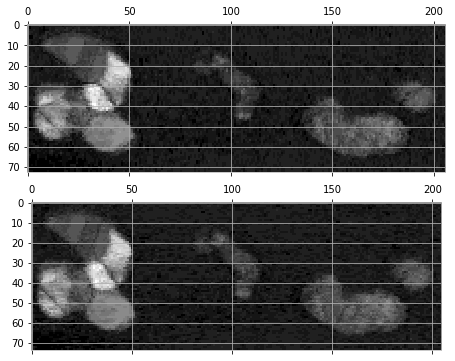

In [23]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(dx_intersections)
ax2.matshow(dy_intersections)
plt.show()

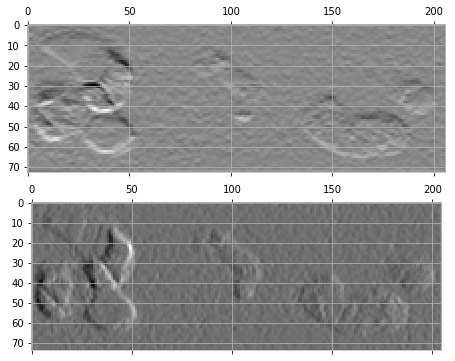

In [24]:
from scipy.signal import convolve2d

sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
sobel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(convolve2d(dx_intersections,sobel_x,mode='same'))
ax2.matshow(convolve2d(dy_intersections,sobel_y,mode='same'))
plt.show()

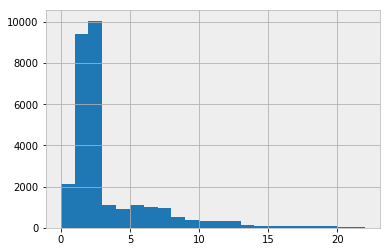

In [25]:
intersections_1d = np.hstack((dx_intersections.ravel(),dy_intersections.ravel()))

fig,ax=plt.subplots()
ax.hist(intersections_1d,bins=np.arange(max(intersections_1d)))
plt.show()

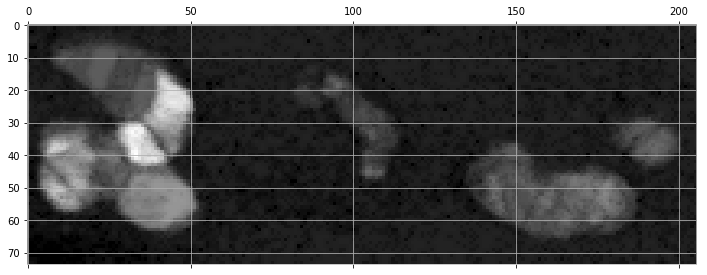

In [26]:
# Get the mean connectedness to 8 NN's
# Find the maxima of this quantity. (Apply small gaussian smoothing, identify local maxima, possibly some thresholding)
# Use these points as seeds for new classes.

mean_NN_intersections = np.zeros((R_Nx,R_Ny))

for rx in range(R_Nx):
    for ry in range(R_Ny):
        mean_NN_intersections[rx,ry] = get_mean_NN_intersection(rx,ry)

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(mean_NN_intersections)
plt.show()

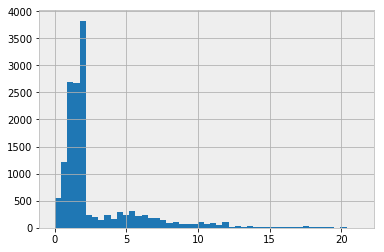

In [27]:
# Histogram
fig,ax=plt.subplots()
ax.hist(mean_NN_intersections.ravel(),bins=np.linspace(0,np.max(mean_NN_intersections),50))
plt.show()

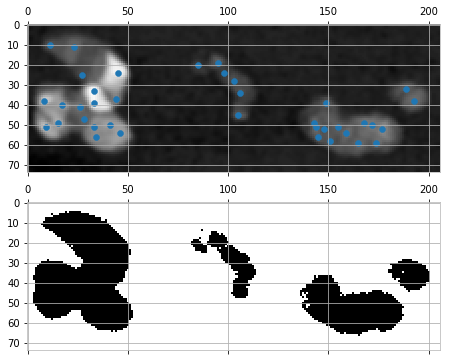

In [28]:
# Get background class mask
# Blur and find local maxima

sigma = 1
thresh_meanNNint = 3

background = mean_NN_intersections < thresh_meanNNint

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = []
for i in range(len(maxima_x)):
    if mean_NN_intersections[maxima_x[i],maxima_y[i]]>thresh_meanNNint:
        seeds.append([maxima_x[i],maxima_y[i]])
seeds = np.array(seeds)
        
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds[:,1],seeds[:,0])
ax2.matshow(background)
plt.show()

# The Classlabel class

In [29]:
class Classlabel(object):
    """
    The classlabel object contains data pertaining to a single classified region of real space.
    It is a python class object used to classify space into k classes; a class class, if you will. So classy!
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (a boolean array,
    self.mask) which are understood to be members of this class.  Physically, each class is understood to correspond
    to a set of Bragg peaks; the relationship between these peaks in Q-space is left unspecified.
    
    Some diffraction pattern containing the set of Bragg peaks s is deemed more likely to be a member of the class
    if it minimizes the cost function
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    Here, the sum is over the set of all N Bragg peaks observed in all the DPs, and:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class. (We take a mean. self.y is self.w > thresh)
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    A Classlabel must be initialized with some starting scan positions, rx, ry, with which to construct and initialize
    self.mask, self.y, and self.w.  We construct self.w from the DPs indicated by rx,ry; self.w[i] is the fraction 
    of class DPs containing the i'th BP.  self.y is given by self.y = self.w > thresh; choose wisely.

    After initialization, we can:
        -get growth mask
        -get cost functions
        -grow
        -shrink?
        -convergence criterion?
    """    
    def __init__(self,index,rx,ry,N,V,thresh):
        """
        Initialize a Classlabel object. 
        
        Accepts:
            index       (int) the class index
            rx,ry       (ints or arrays of ints) initial scan positions
            N           (int) the number of indexed BPs
            V           (float) scales penalty for nonoverlapped Bragg peaks
            thresh      (float) min value of self.w[i] at which self.y[i] is set to True
            
        """
        # Class parameters
        self.index = index
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.thresh = thresh
        self.V = V
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.Ny = 0
        self.my_cost = 0
            
        # Add initial points
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.Ny += 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.Ny += 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.Ny -= 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.Ny -= 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        
    def get_w(self):
        self.w = self.counts_per_BP/self.Ny
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def cost(self,s):
        """ $ c = -\sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i) $ 
        """
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_my_cost(self):
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets_by_scan_position[rx[i]][ry[i]]
            cost += self.cost(s)
        self.my_cost = cost
        return self.my_cost
    
    def s_to_array(self,s):
        ans = np.zeros(self.N,dtype=bool)
        for i in s:
            ans[i] = True
        return ans

### Get a first, background class

In [30]:
# Parameters

thresh_meanNNint = 3
V = 2
thresh = 0.05

# Bookkeeping
N_classes = 0
labelled = np.zeros((R_Nx,R_Ny),dtype=bool)   # True for scan positions which have been placed in a class

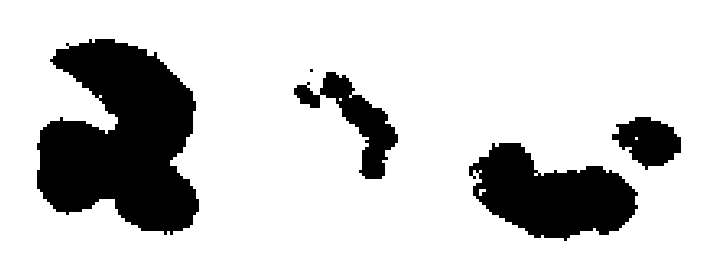

In [31]:
# Get background

background = mean_NN_intersections < thresh_meanNNint

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(background)
ax.axis('off')
plt.show()

In [32]:
# Make a background class

rx,ry = np.nonzero(background)
background_class = Classlabel(index=N_classes, rx=rx, ry=ry, N=voronoi.npoints, V=V, thresh=thresh)
N_classes+=1
labelled = np.where(background,True,labelled)   # Mark backgroung pixels as in a class

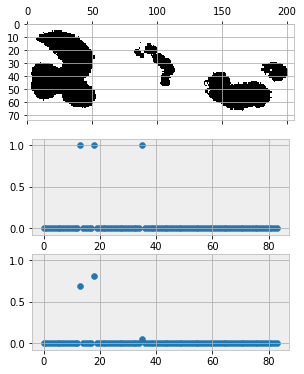

In [33]:
# Show class.mask, class.y

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,6))
ax1.matshow(background_class.mask)
ax2.scatter(np.arange(background_class.N),background_class.y)
ax2.set_aspect(aspect=0.35*background_class.N)
ax2.set_ylim([-0.08,1.08])
ax3.scatter(np.arange(background_class.N),background_class.y*background_class.w)
ax3.set_aspect(aspect=0.35*background_class.N)
ax3.set_ylim([-0.08,1.08])
plt.show()

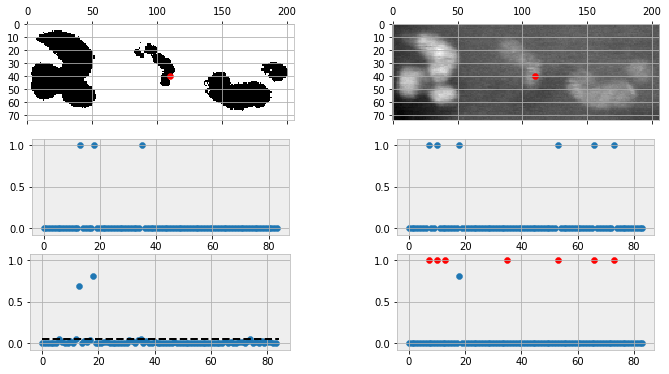

Cost = 13.192343843458943


In [34]:
# Compare class to a DP

rx,ry = 40,110
s = braggpeak_sets_by_scan_position[rx][ry]
x = background_class.s_to_array(s)

fig,((ax_L1,ax_R1),(ax_L2,ax_R2),(ax_L3,ax_R3)) = plt.subplots(3,2,figsize=(12,6))

ax_L1.matshow(background_class.mask)
ax_L1.scatter(ry,rx,color='r')
ax_L2.scatter(np.arange(background_class.N),background_class.y)
ax_L2.set_aspect(aspect=0.35*background_class.N)
ax_L2.set_ylim([-0.08,1.08])
ax_L3.scatter(np.arange(background_class.N),background_class.w)
ax_L3.hlines(background_class.thresh,0,background_class.N,linestyle='--')
ax_L3.set_aspect(aspect=0.35*background_class.N)
ax_L3.set_ylim([-0.08,1.08])

ax_R1.matshow(ave_im)
ax_R1.scatter(ry,rx,color='r')
ax_R2.scatter(np.arange(background_class.N),x)
ax_R2.set_aspect(aspect=0.35*background_class.N)
ax_R2.set_ylim([-0.08,1.08])
ax_R3.scatter(np.arange(background_class.N),x*background_class.y*background_class.w)
xorx = np.nonzero(np.logical_xor(x,background_class.y))[0]
ax_R3.scatter(xorx,np.ones_like(xorx),color='r')
ax_R3.set_aspect(aspect=0.35*background_class.N)
ax_R3.set_ylim([-0.08,1.08])

plt.show()
print("Cost = {}".format(background_class.cost(s)))

### Make and grow and new class

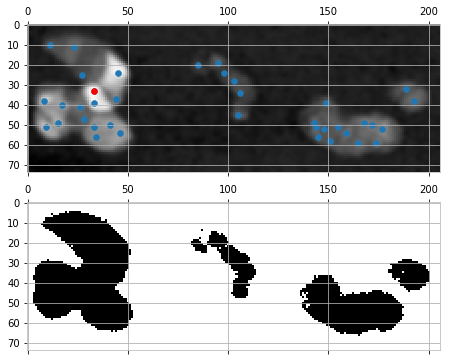

In [35]:
# Get possible locations for seeding new classes
#
# Start with mean intersections.  Apply mild blur, find local maxima.
# When a new seed is needed, get maximum with next-largest mean intersection

sigma = 1
thresh_meanNNint = 3

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = py4DSTEM.file.datastructure.PointList(coordinates=[('rx',int),('ry',int),('intersection',float)])
for i in range(len(maxima_x)):
    if blurred_mean_intersections[maxima_x[i],maxima_y[i]] > thresh_meanNNint:
        seeds.add_point((maxima_x[i],maxima_y[i],blurred_mean_intersections[maxima_x[i],maxima_y[i]]))
seeds.sort('intersection','descending')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(labelled)
plt.show()

In [36]:
# Make a new class. Use maximum and 8 NNs

# Get seed center
rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

# Get adjacent pixels, handling edges
rx_min = rx0 - 1*(rx0>0)
ry_min = ry0 - 1*(ry0>0)
rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
rx,ry = rxx.ravel(),ryy.ravel()

# Make the new class
current_class = Classlabel(index=N_classes, rx=rx, ry=ry, N=voronoi.npoints, V=V, thresh=thresh)
N_classes+=1
labelled[rx,ry] = True   # Mark backgroung pixels as in a class

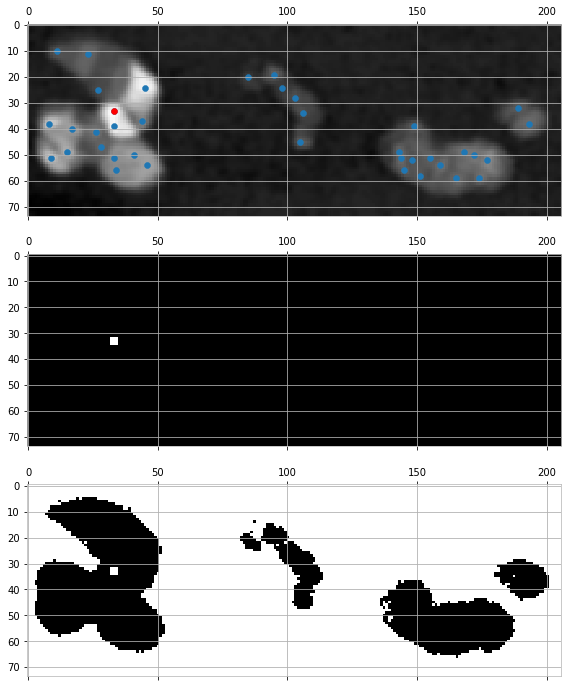

In [37]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(current_class.mask)
ax3.matshow(labelled)
plt.show()

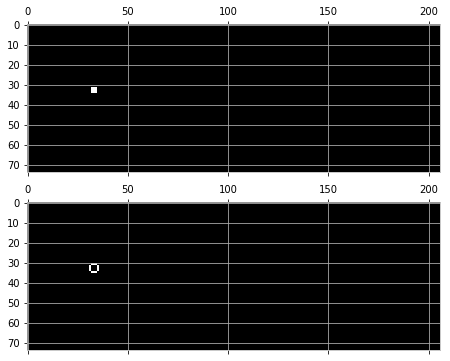

In [38]:
# Get all NN

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

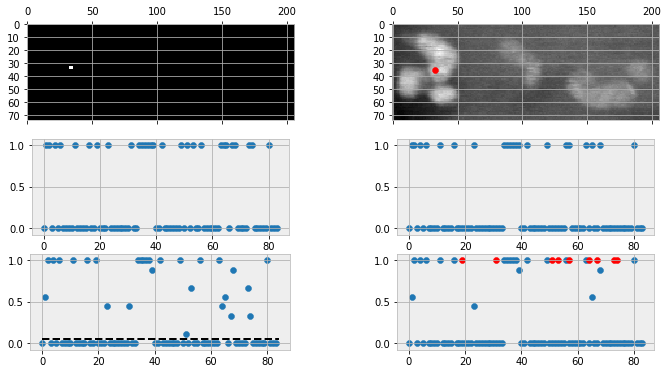

Cost = -0.33333333333333215


In [39]:
# Compare class some of these DPs

r_index = 10

rx,ry = np.nonzero(growth_mask)
rx,ry = rx[r_index],ry[r_index]
s = braggpeak_sets_by_scan_position[rx][ry]
x = current_class.s_to_array(s)

fig,((ax_L1,ax_R1),(ax_L2,ax_R2),(ax_L3,ax_R3)) = plt.subplots(3,2,figsize=(12,6))

ax_L1.matshow(current_class.mask)
#ax_L1.scatter(ry,rx,color='r')
ax_L2.scatter(np.arange(current_class.N),current_class.y)
ax_L2.set_aspect(aspect=0.35*current_class.N)
ax_L2.set_ylim([-0.08,1.08])
ax_L3.scatter(np.arange(current_class.N),current_class.w)
ax_L3.hlines(current_class.thresh,0,current_class.N,linestyle='--')
ax_L3.set_aspect(aspect=0.35*current_class.N)
ax_L3.set_ylim([-0.08,1.08])

ax_R1.matshow(ave_im)
ax_R1.scatter(ry,rx,color='r')
ax_R2.scatter(np.arange(current_class.N),x)
ax_R2.set_aspect(aspect=0.35*current_class.N)
ax_R2.set_ylim([-0.08,1.08])
ax_R3.scatter(np.arange(current_class.N),x*current_class.y*current_class.w)
xorx = np.nonzero(np.logical_xor(x,current_class.y))[0]
ax_R3.scatter(xorx,np.ones_like(xorx),color='r')
ax_R3.set_aspect(aspect=0.35*current_class.N)
ax_R3.set_ylim([-0.08,1.08])

plt.show()
print("Cost = {}".format(current_class.cost(s)))

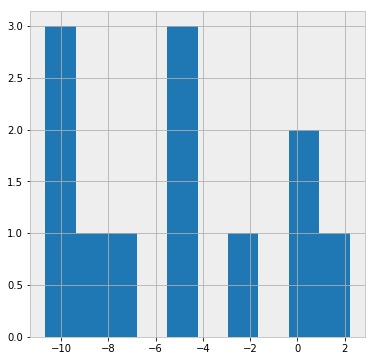

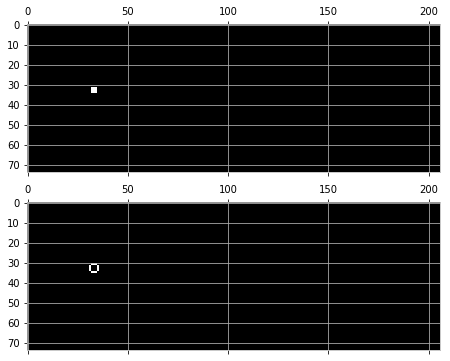

In [40]:
costs = np.zeros_like(np.nonzero(growth_mask)[0])

rx_test,ry_test = np.nonzero(growth_mask)
costs = np.zeros(len(rx_test))

for i in range(len(rx_test)):
    s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
    costs[i] = current_class.cost(s)
    
fig,ax=plt.subplots(figsize=(6,6))
ax.hist(costs)
plt.show()

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(growth_mask)
plt.show()

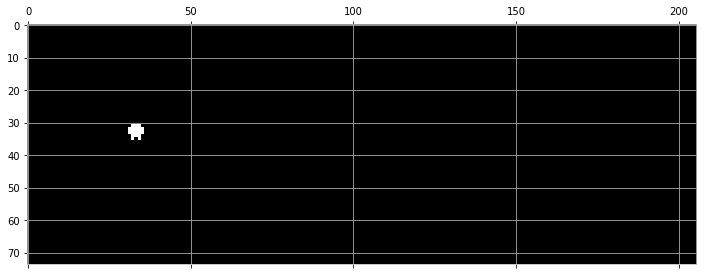

In [41]:
# One growth iteration

growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
rx_test,ry_test = np.nonzero(growth_mask)
costs = np.zeros(len(rx_test))

for i in range(len(rx_test)):
    s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
    costs[i] = current_class.cost(s)
    if costs[i] < 0:
        current_class.add_data_by_scan_position(rx_test[i],ry_test[i])
        labelled[rx_test[i],ry_test[i]] = True

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(current_class.mask)
plt.show()

In [42]:
# One growth iteration

proceed = True
while proceed:
    growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
    rx_test,ry_test = np.nonzero(growth_mask)
    costs = np.zeros(len(rx_test))
    for i in range(len(rx_test)):
        s = braggpeak_sets_by_scan_position[rx_test[i]][ry_test[i]]
        costs[i] = current_class.cost(s)
        if costs[i] < 0:
            current_class.add_data_by_scan_position(rx_test[i],ry_test[i])
            labelled[rx_test[i],ry_test[i]] = True     
    if np.any(costs < 0):
        proceed = True
    else:
        proceed = False

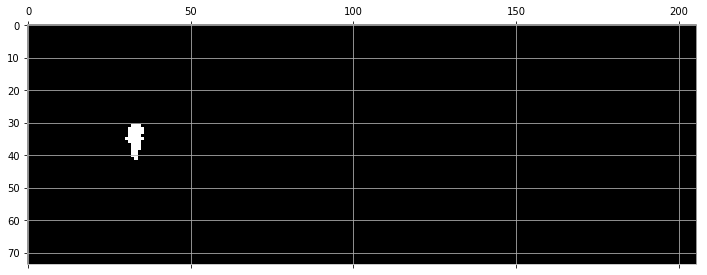

In [43]:
# Show

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(current_class.mask)
plt.show()

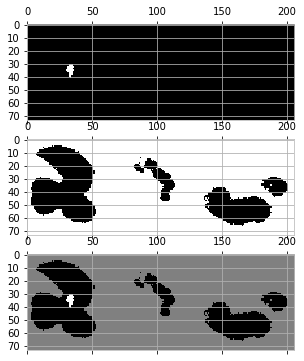

In [44]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,6))
ax1.matshow(current_class.mask)
ax2.matshow(background_class.mask)
ax3.matshow(background_class.mask+2*current_class.mask)
plt.show()

In [45]:
class Classification(object):
    """
    A classification of a 4D STEM dataset.
    
    A classification object consists of:
        
        classification      (shape (Rx,Ry) array of ints) the class labels k at each scan position
        classes             (len N_classes list of Classlabel objects) the classes
    
    It has the following methods:
        
        new_class(rx,ry)           creates a new class, from the scan position(s) rx,ry
        get_class_mask(i)          returns an (Rx,Ry) ndarray of bools specifying class i scan positions
        grow_class(i,cost_thresh)  expands class i until all its NN DPs have cost >= cost_thresh
        erode_class(i,cost_thresh) erodes class i until all its NN DPs have cost < cost_thresh
    """
    def __init__(self,R_Nx,R_Ny,V,thresh,braggpeak_sets_by_scan_position):
        self.R_Nx, self.R_Ny = R_Nx,R_Ny
        self.classification = -np.ones((self.R_Nx,self.R_Ny),dtype=int)
        self.classes = []
        
        self.V = V
        self.thresh = thresh
        
        self.N_classes = 0
        self.class_indices = []
        self.labelled = np.zeros((self.R_Nx,self.R_Ny),dtype=bool)
        
        self.braggpeak_sets_by_scan_position = braggpeak_sets_by_scan_position
    
    def new_class(self, rx, ry):
        self.N_classes+=1
        self.class_indices=np.arange(self.N_classes)
        curr_class_index = self.class_indices[-1]
        new_class = Classlabel(index=curr_class_index, rx=rx, ry=ry, N=voronoi.npoints, V=self.V, thresh=self.thresh)
        self.classes.append(new_class)
        self.labelled[rx,ry] = True
        self.classification[rx,ry] = curr_class_index
        
    def get_class_mask(self,i):
        return self.classification==i
    
    def grow_class(self,i,cost_thresh):
        current_class = self.classes[i]
        proceed = True
        while proceed:
            growth_mask = np.logical_xor(current_class.mask,binary_dilation(current_class.mask))
            rx,ry = np.nonzero(growth_mask)
            costs = np.zeros(len(rx))
            for j in range(len(rx)):
                s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                costs[j] = current_class.cost(s)
                if costs[j] < cost_thresh:
                    current_class.add_data_by_scan_position(rx[j],ry[j])
                    self.labelled[rx[j],ry[j]] = True
                    self.classification[rx[j],ry[j]] = i
            if np.any(costs < cost_thresh):
                proceed = True
            else:
                proceed = False

    def erode_class(self,i,cost_thresh):
        current_class = self.classes[i]
        proceed = True
        while proceed:
            erosion_mask = np.logical_xor(current_class.mask,binary_erosion(current_class.mask))
            rx,ry = np.nonzero(erosion_mask)
            costs = np.zeros(len(rx))
            for j in range(len(rx)):
                s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                costs[j] = current_class.cost(s)
                if costs[j] >= cost_thresh:
                    current_class.remove_data_by_scan_position(rx[j],ry[j])
                    self.labelled[rx[j],ry[j]] = False  
                    self.classification[rx[j],ry[j]] = -1
            if np.any(costs >= cost_thresh):
                proceed = True
            else:
                proceed = False

#### Away we go :D

In [46]:
V = 1
thresh = 0.05
growth_thresh = 4
erosion_thresh = 4

classification = Classification(R_Nx,R_Ny,V,thresh,braggpeak_sets_by_scan_position)

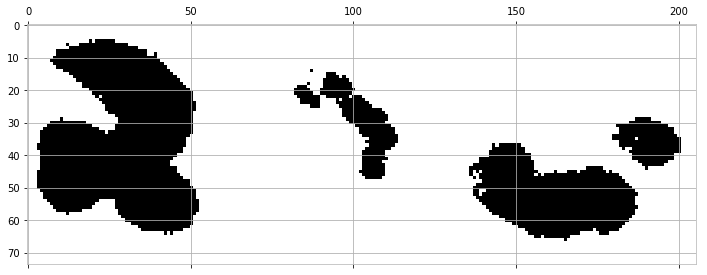

In [47]:
# Make a background class

background = mean_NN_intersections < thresh_meanNNint

rx,ry = np.nonzero(background)
classification.new_class(rx,ry)

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(classification.get_class_mask(0))
plt.show()

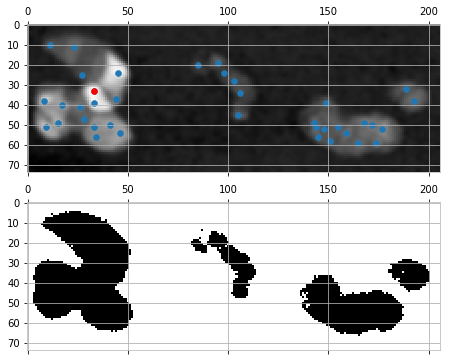

In [48]:
# Get possible locations for seeding new classes
#
# Start with mean intersections.  Apply mild blur, find local maxima.
# When a new seed is needed, get maximum with next-largest mean intersection

sigma = 1
thresh_meanNNint = 3

blurred_mean_intersections = gaussian_filter(mean_NN_intersections,sigma)
maxima_x, maxima_y = np.nonzero(py4DSTEM.process.utils.get_maximal_points(blurred_mean_intersections))

seeds = py4DSTEM.file.datastructure.PointList(coordinates=[('rx',int),('ry',int),('intersection',float)])
for i in range(len(maxima_x)):
    if blurred_mean_intersections[maxima_x[i],maxima_y[i]] > thresh_meanNNint:
        seeds.add_point((maxima_x[i],maxima_y[i],blurred_mean_intersections[maxima_x[i],maxima_y[i]]))
seeds.sort('intersection','descending')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.labelled)
plt.show()

In [49]:
# Make a new class. Use maximum and 8 NNs

# Get seed center
rx0,ry0 = seeds.data['rx'][0],seeds.data['ry'][0]

# Get adjacent pixels, handling edges
rx_min = rx0 - 1*(rx0>0)
ry_min = ry0 - 1*(ry0>0)
rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
rx,ry = rxx.ravel(),ryy.ravel()

# Make the new class
classification.new_class(rx,ry)

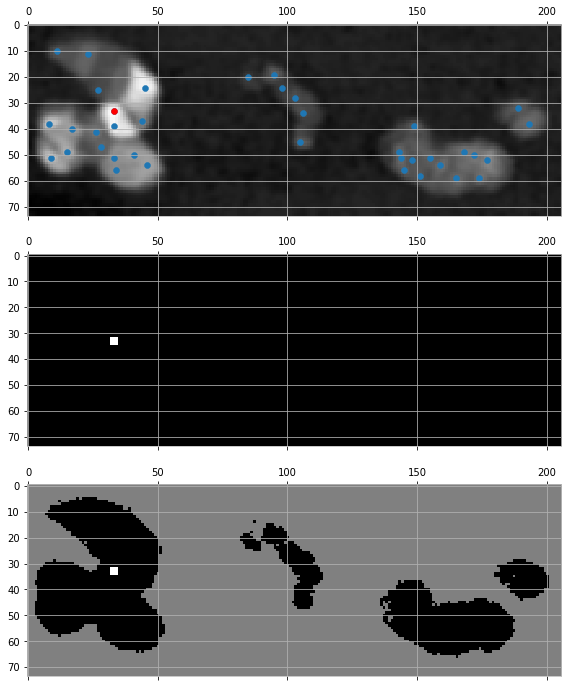

In [50]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(1))
ax3.matshow(classification.classification)
plt.show()

In [51]:
# Grow the class

classification.grow_class(1,cost_thresh=growth_thresh)
classification.erode_class(1,cost_thresh=growth_thresh)

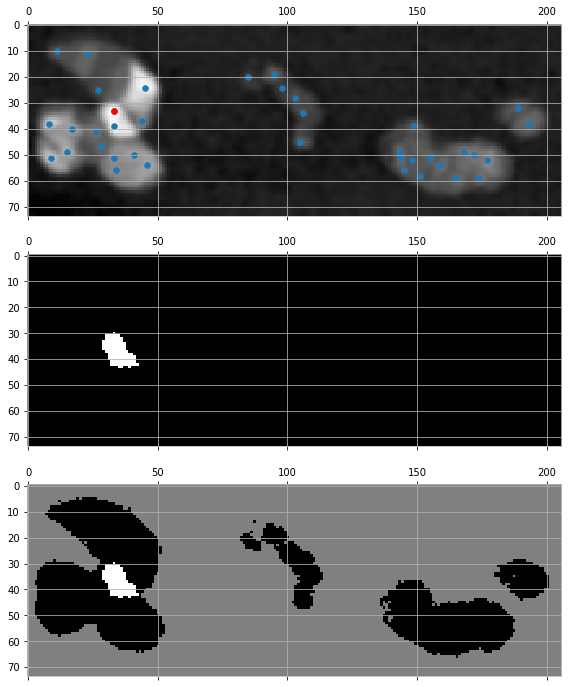

In [52]:
# Show

fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(1))
ax3.matshow(classification.classification)
plt.show()

In [53]:
# Grow/erode the classes

classification.grow_class(1,cost_thresh=growth_thresh)
classification.erode_class(1,cost_thresh=erosion_thresh)

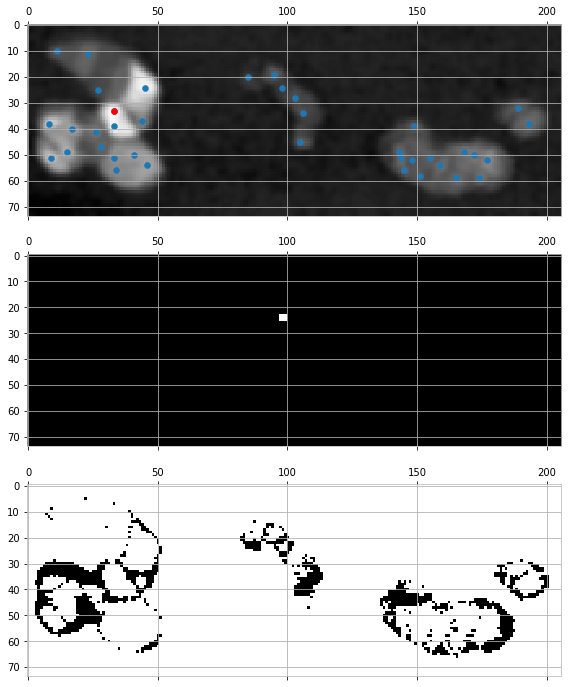

In [54]:
# Make a bunch of new classes.

r = zip(seeds.data['rx'][1:],seeds.data['ry'][1:])

for rx0,ry0 in r:

    # Get adjacent pixels, handling edges
    rx_min = rx0 - 1*(rx0>0)
    ry_min = ry0 - 1*(ry0>0)
    rx_max = rx0 + 1 + 1*(rx0<(R_Nx-1))
    ry_max = ry0 + 1 + 1*(ry0<(R_Ny-1))
    rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
    rx,ry = rxx.ravel(),ryy.ravel()

    # Make the new class
    classification.new_class(rx,ry)
    classification.grow_class(classification.N_classes-1,cost_thresh=growth_thresh)

# Show
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12))
ax1.matshow(blurred_mean_intersections)
ax1.scatter(seeds.data['ry'],seeds.data['rx'])
ax1.scatter(seeds.data['ry'][0],seeds.data['rx'][0],color='r')
ax2.matshow(classification.get_class_mask(classification.N_classes-1))
ax3.matshow(classification.classification!=-1)
plt.show()

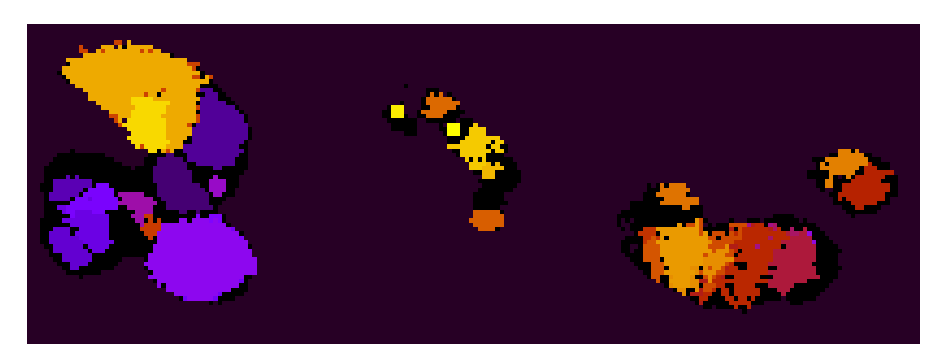

In [55]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification,cmap='gnuplot')
ax.axis('off')
plt.show()

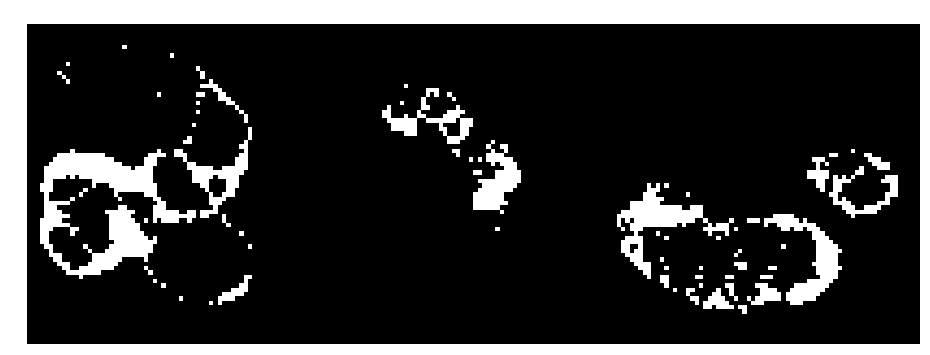

In [56]:
# Find unassigned regions

# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification==-1)
ax.axis('off')
plt.show()

In [57]:
initial_classification = np.copy(classification.classification)

#### Save

In [62]:
initial_classification_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(data=initial_classification,
                                                                                name='initial_classification')

#fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
py4DSTEM.file.readwrite.append(initial_classification_diffslice,fp)

Opening file /Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5...
Done.


In [63]:
coordinates=[('i',int)]
bragg_peaks_by_scan_position_pla = py4DSTEM.file.datastructure.PointListArray(coordinates, (R_Nx,R_Ny),
                                                                              name='braggpeak_sets_by_scan_position_pla')
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        pl = bragg_peaks_by_scan_position_pla.get_pointlist(Rx,Ry)
        s = braggpeak_sets_by_scan_position[Rx][Ry]
        for i in s:
            pl.add_point([i])
            
#fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
py4DSTEM.file.readwrite.append(bragg_peaks_by_scan_position_pla,fp)

Opening file /Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5...
Done.


# New Classification and ClassLabel objects

In [69]:
class Classification(object):
    """
    A classification of a 4D STEM dataset.
    
    A classification object consists of two states: the current state and the next state.
    For each state, there is a:
        classification      (shape (Rx,Ry) array of ints) the class labels k at each scan position
        classes             (len N_classes list of ClassLabel objects) the classes
        cost                (float) measure to minimize
    A classification has the following methods:
        new_class(rx,ry)           generate a possible next state by seeding a new class from scan position rx,ry + NNs
        grow_class(i)              generate a possible next state by expanding class i
        merge_classes(i,j)         generate a possible next state by merging classes i and j
        get_new_state()            gets a possible next state with one of the previous three methods, and updates next_state
        accept_next_state()        current state := next_state; next_state := new_state
        reject_next_state()        current state := current_state; next_state := new_state
        get_current_cost()         get the cost of the current state
        get_next_cost()            get the cost of the next state
        get_class_mask(i)          returns an (Rx,Ry) ndarray of bools specifying class i scan positions
    The classification object may be initialized with a 2D array of ints, giving the class values k; if this is
    provided, the classification object will initialize a set of classlabel objects accordingly.
    """
    def __init__(self,R_Nx,R_Ny,V,thresh,braggpeak_sets_by_scan_position,alpha,
                 unclassified_cost,grow_merge_new_ratio=[1,20,20],N_rand_positions=20,classification=None):
        """Accepts:
                R_Nx,R_Ny                      (ints) scan shape
                V,thresh                       (floats) cost function and ClassLabel parameters
                bragg_peaks_by_scan_position   (list of lists of sets) the set of Bragg peaks by scan position
                alpha                          (float) the cost of having additional classes
                unclassified_cost              (float) the cost of having an unclassified pixel
                grow_merge_new_ratio           (length-3 list of ints) when time-evolving, ratio of grow/merge/new steps attempted
                classification                 (shape (R_Nx,R_Ny) array of ints) an initial classification
        """
        self.R_Nx, self.R_Ny = R_Nx,R_Ny
        self.classification_current = -np.ones((self.R_Nx,self.R_Ny),dtype=int)   # -1 refers to a pixel which is
        self.classification_next = -np.ones((self.R_Nx,self.R_Ny),dtype=int)      # as-yet unassigned to a class
        self.classes_current = []
        self.classes_next = []
        self.N_classes_current = 0
        self.N_classes_next = 0
        self.class_indices_current = []
        self.class_indices_next = []
        self.class_index_current = 0
        self.class_index_next = 0
        self.cost_current = 0
        self.cost_next = 0
        
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny),dtype=int)     # -2 refers to unchanged pixels
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny),dtype=int)    # 0 and -1 are already in use!
        self.t=0
        self.N_rand_positions = N_rand_positions
        self.get_grow_merge_new_steps(grow_merge_new_ratio)            # Defines self.steps, specifying when
                                                                             # to attempt which type of new state
        self.alpha = alpha
        self.V = V
        self.thresh = thresh
        self.braggpeak_sets_by_scan_position = braggpeak_sets_by_scan_position
        self.unclassified_cost = unclassified_cost
        
        if classification is not None:
            self.get_current_state_from_classification(classification)
            self.get_next_state_from_current_state()
    
    def get_new_state(self):
        """Updates to the next state.
        
           Assumes next_state begins in the same state as current_state; this is ensured as long as
           self.accept_next_state() or self.reject_next_state() has been run since the last self. get_new_state() call.
           
           Generates two (R_Nx,R_Ny) arrays of ints: delta_forward and delta_backward. 
           These store changes so that rejected changes in next state can be reverted if needed.
           In both, -2 represents no change, a number represents the class to change this pixel to.
  
           delta_forward and delta_backward are generated by calling new_class, grow_class, or merge_class.
           Which is called is controlled by the class parameter 
        """
                
        COST = 0
        
        # Choose a new step type 
        step_type = self.steps[self.t%(len(self.steps))]
        self.t += 1
        if step_type==1:
            rx,ry = self.select_new_seed_positions()
            self.new_class(rx,ry)
        elif step_type==2:
            i = self.select_a_class()
            self.grow_class(i)
        elif step_type==3:
            i,j = self.select_class_pair()
            self.merge_classes(i,j)
        else:
            raise Exception("Error: step_type must be 1,2, or 3, not {}".format(step_type))
        
        # Set next state, and its cost, from the lists of new, removed, and changed classlabels
        self.classification_next = np.where(self.delta_forward!=-2,self.delta_forward,self.classification_next)
        for new_class_index in self.new_class_indices:
            mask = self.delta_forward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=voronoi.npoints,V=self.V,thresh=self.thresh)
            self.classes_next.append(new_class)
            self.class_indices_next.append(new_class_index)
            self.class_index_next += 1
            self.N_classes_next += 1
            # TODO: why does this assertion fail?
            #assert(np.all(self.classification_next[mask] == new_class_index))
            COST += new_class.my_cost
        for removed_class_index in self.removed_class_indices:
            removed_class = self.get_class_next(removed_class_index)
            self.classes_next.remove(removed_class)
            self.class_indices_next.remove(removed_class_index)
            self.N_classes_next -= 1
            COST -= removed_class.my_cost
            del removed_class
        for grown_class_index in self.grown_class_indices:
            if grown_class_index!=-1:
                grown_class = self.get_class_next(grown_class_index)
                mask = self.delta_forward==grown_class_index
                rx,ry = np.nonzero(mask)
                cost_temp = grown_class.my_cost
                grown_class.add_data_by_scan_position(rx,ry)
                COST += (grown_class.my_cost - cost_temp)
            else:
                mask = self.delta_forward==grown_class_index
                COST += self.unclassified_cost * np.sum(mask)
        for eroded_class_index in self.eroded_class_indices:
            eroded_class = self.get_class_next(eroded_class_index)
            mask = self.delta_backward==eroded_class_index
            rx,ry = np.nonzero(mask)
            if eroded_class_index!=-1:
                cost_temp = eroded_class.my_cost
                eroded_class.remove_data_by_scan_position(rx,ry)
                COST += (eroded_class.my_cost - cost_temp)
            else:
                COST = self.unclassified_cost * np.sum(mask)

        COST += self.alpha * (self.N_classes_next-self.N_classes_current)
        COST += self.unclassified_cost * (np.sum(self.classification_next==-1)-np.sum(self.classification_next==-1))

        print('N_classes = {}'.format(self.N_classes_next))
        print(COST)
        
        if COST < 0:
            self.accept_next_state()
        else:
            self.reject_next_state()

        return COST


    def new_class(self,rx,ry):
        """Generates a possible next state by seeding a new class from the scan position rx,ry and its 8 NNs.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.eroded_class_indices = []
        self.grown_class_indices = []
        # Get set of all NN pixels, handling edges
        rx_min = rx - 1*(rx>0)
        ry_min = ry - 1*(ry>0)
        rx_max = rx + 1 + 1*(rx<(self.R_Nx-1))
        ry_max = ry + 1 + 1*(ry<(self.R_Ny-1))
        rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
        rx,ry = rxx.ravel(),ryy.ravel()
        # Add the changes to delta_forward and delta_backward
        new_class_index = self.class_index_next   # Don't increment self.class_index_next; we haven't actually added it yet!
        eroded_classes_temp = []
        for j in range(len(rx)):
            i = self.classification_next[rx[j],ry[j]]
            self.delta_backward[rx[j],ry[j]] = i
            self.delta_forward[rx[j],ry[j]] = new_class_index
            eroded_classes_temp.append(i)
        # Get any new / erode / remove classes
        self.new_class_indices.append(new_class_index)
        eroded_classes_temp = set(eroded_classes_temp)
        for eroded_class_index in eroded_classes_temp:
            if eroded_class_index not in self.classification_next[self.delta_forward==-2]:
                self.removed_class_indices.append(eroded_class_index)
            else:
                self.eroded_class_indices.append(eroded_class_index)
        return
        
    def grow_class(self,i):
        """Generates a possible next state by growing class i into adjacent cells which will reduce the total cost.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.grown_class_indices = []
        self.eroded_class_indices = []
        # Get class, possible growth pixels
        growing_class = self.get_class_next(i)
        growth_mask = np.logical_xor(growing_class.mask,binary_dilation(growing_class.mask))
        rx,ry = np.nonzero(growth_mask)
        # Determine if each pixel will raise or lower cost, and construct delta_forward/delta_backward
        self.grown_class_indices = [i]
        for j in range(len(rx)):
            s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]] # The BPs at the cell in question
            i_eroded = self.classification_next[rx[j],ry[j]]       # The index of the class being eroded
            if i_eroded != -1:
                #print(i_eroded)
                #for i in range(len(self.classes_next)):
                #    print(self.classes_next[i].index)
                eroded_class = self.get_class_next(i_eroded)
                cost_eroded = eroded_class.cost(s)                 # The cost of this cell in the eroded class
            else:
                cost_eroded = unclassified_cost                    # Cost for losing an unassigned pixel
            cost_growing = growing_class.cost(s)                   # The cost of this cell in the growing class
            
            if cost_growing < cost_eroded:
                self.delta_forward[rx[j],ry[j]] = i
                self.delta_backward[rx[j],[ry[j]]] = i_eroded
                self.eroded_class_indices.append(i_eroded)
        # Get any changed or removed classes
        self.eroded_class_indices = set(self.eroded_class_indices)
        for eroded_class_index in self.eroded_class_indices:
            if eroded_class_index not in self.classification_next[self.delta_forward==-2]:
                self.eroded_class_indices.remove(eroded_class_index)
                self.removed_class_indices.append(eroded_class_index)
        return   
        
    def merge_classes(self,i,j):
        """Generates a possible next state by merging class i into class j.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.grown_class_indices = []
        self.eroded_class_indices = []
        # Get classes
        growing_class = self.get_class_next(j)
        eroding_class = self.get_class_next(i)
        # Populate delta_forward and delta_backward
        self.delta_forward[self.classification_current==i] = j
        self.delta_backward[self.classification_current==i] = i
        self.removed_class_indices.append(i)
        self.grown_class_indices.append(j)
        return

    def accept_next_state(self):
        """Sets current_state := next_state; next_state := next_state.
        """
        classification_temp = np.copy(self.classification_next)
        self.classification_current = self.classification_next
        self.classification_next = classification_temp

        N_classes_temp = np.copy(self.N_classes_next)
        self.N_classes_current = self.N_classes_next
        self.N_classes_next = N_classes_temp
        
        class_indices_temp = [np.copy(index) for index in self.class_indices_current]
        self.class_indices_current = self.class_indices_next
        self.class_indices_next = class_indices_temp
        
        class_index_temp = np.copy(self.class_index_next)
        self.class_index_current = self.class_index_next
        self.class_index_next = class_index_temp
        
        # Time evolving the classes
        # Update the current next state
        self.classification_current = np.where(self.delta_forward!=-2,self.delta_forward,self.classification_current)     
        for new_class_index in self.new_class_indices:
            mask = self.delta_forward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=voronoi.npoints,V=self.V,thresh=self.thresh)
            self.N_classes_current += 1
            self.class_indices_current.append(self.class_index_next)
            self.class_index_current += 1
            assert(np.all(self.classification_current[mask] == new_class_index))
        for removed_class_index in self.removed_class_indices:
            removed_class = self.get_class_current(removed_class_index)
            self.classes_current.remove(removed_class)
            self.class_indices_current.remove(removed_class_index)
            self.N_classes_current -= 1
            del removed_class
        for grown_class_index in self.grown_class_indices:
            grown_class = self.get_class_current(grown_class_index)
            mask = self.delta_forward==grown_class_index
            rx,ry = np.nonzero(mask)
            grown_class.add_data_by_scan_position(rx,ry)
        for eroded_class_index in self.eroded_class_indices:
            eroded_class = self.get_class_current(eroded_class_index)
            mask = self.delta_backward==eroded_class_index
            rx,ry = np.nonzero(mask)
            eroded_class.remove_data_by_scan_position(rx,ry)
    
    def reject_next_state(self):
        """Leaves current state unchanged. Reverts next_state := current_state.
        """
        classification_next = np.copy(self.classification_current)
        self.N_classes_next = np.copy(self.N_classes_current)
        #self.class_indices_next = [np.copy(index) for index in self.class_indices_current]
        self.class_index_next = np.copy(self.class_index_current)
        
        # Time evolving the classes
        # Reset the next state to the current state
        self.classification_next = np.where(self.delta_backward!=-2,self.delta_backward,self.classification_next)      
        for removed_class_index in self.new_class_indices:          # Remove the new classes...
            removed_class = self.get_class_next(removed_class_index)
            self.classes_next.remove(removed_class)
            self.class_indices_next.remove(removed_class_index)
            self.N_classes_next -= 1
            del removed_class
        for new_class_index in self.removed_class_indices:          # ...and add the removed classes
            mask = self.delta_backward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=voronoi.npoints,V=self.V,thresh=self.thresh)
            self.classes_next.append(new_class)
            self.class_indices_next.append(new_class_index)
            self.N_classes_next += 1
            assert(np.all(self.classification_next[mask] == new_class_index))
        for eroded_class_index in self.grown_class_indices:          # Similarly, erode grown classes...
            eroded_class = self.get_class_current(eroded_class_index)
            mask = self.delta_forward==eroded_class_index
            rx,ry = np.nonzero(mask)
            eroded_class.remove_data_by_scan_position(rx,ry)
        for grown_class_index in self.eroded_class_indices:        # ...and grow eroded ones.
            if grown_class_index!=-1:
                grown_class = self.get_class_next(grown_class_index)
                mask = self.delta_backward==grown_class_index
                rx,ry = np.nonzero(mask)
                grown_class.add_data_by_scan_position(rx,ry)
            
    def get_cost_current(self):
        self.cost_current = 0
        for curr_class in self.classes_current:
            self.cost_current += curr_class.my_cost
        self.cost_current += self.alpha * self.N_classes_current
        self.cost_current += self.unclassified_cost*np.sum(self.classification_current==-1)
        return self.cost_current
    
    def get_cost_next(self):
        self.cost_next = 0
        for next_class in self.classes_next:
            self.cost_next += next_class.my_cost
        self.cost_next += self.alpha * self.N_classes_next
        self.cost_next += self.unclassified_cost*np.sum(self.classification_next==-1)
        return self.cost_next            

    def get_grow_merge_new_steps(self, grow_merge_new_ratio):
        """Gets an array indicating whether to grow, merge, or create a new domain at each timestep.
           Grow/merge/new steps at t=i are indicated by values of 1/2/3 in self.steps.
        """
        grow_steps = np.zeros(np.max(grow_merge_new_ratio))
        merge_steps = np.zeros(np.max(grow_merge_new_ratio))
        new_steps = np.zeros(np.max(grow_merge_new_ratio))
        grow_steps[::grow_merge_new_ratio[0]]=1
        merge_steps[::grow_merge_new_ratio[1]]=2
        new_steps[::grow_merge_new_ratio[2]]=3

        self.steps=[]
        all_steps = np.vstack((grow_steps,merge_steps,new_steps)).T
        for step in all_steps:
            for i in np.nonzero(step)[0]:
                self.steps.append(int(step[i]))

    def get_current_state_from_classification(self,classification):
        """Accepts a 2D array of ints. Updates self.classification_current, self.classes_current,
           self.class_indices_current, and self.cost_current.
        """
        self.classes_current = []
        self.class_indices_current = []
        self.classification_current = classification
        self.N_classes_current = 0
        self.class_index_current = 0
        for i in range(np.max(classification)):
            mask = classification==i
            new_class = ClassLabel(index=i, mask=mask, N=voronoi.npoints,V=self.V, thresh=self.thresh)
            self.classes_current.append(new_class)
            self.N_classes_current += 1
            self.class_index_current += 1
            self.class_indices_current.append(i)
        self.cost_current = self.get_cost_current()
        
    def get_next_state_from_current_state(self):
        """Updates next state to match current state. Updates self.classification_next, self.classes_next,
           self.next, and self.cost_next.
        """
        self.classes_next = []
        self.class_indices_next = []
        self.classification_next = self.classification_current
        self.N_classes_next = 0
        self.class_index_next = 0
        for i in range(np.max(self.classification_current)):
            mask = self.classification_current==i
            new_class = ClassLabel(index=i, mask=mask, N=voronoi.npoints,V=self.V, thresh=self.thresh)
            self.classes_next.append(new_class)
            self.N_classes_next += 1
            self.class_index_next += 1
            self.class_indices_next.append(i)
        self.cost_next = self.get_cost_next()

    def get_class_current(self,i):
        """If a ClassLabel instance with index=i is in the current class list, return it
        """
        for curr_class in self.classes_current:
            if curr_class.index == i:
                return curr_class
        return None
    
    def get_class_next(self,i):
        """If a ClassLabel instance with index=i is in the next class list, return it
        """
        for next_class in self.classes_next:
            if next_class.index == i:
                return next_class
        return None

    def get_class_mask_current(self,i):
        return self.classification_current==i
    
    def get_class_mask_next(self,i):
        return self.classification_next==i
    
    def select_new_seed_positions(self):
        rx = np.random.randint(0,self.R_Nx,size=self.N_rand_positions)
        ry = np.random.randint(0,self.R_Ny,size=self.N_rand_positions)
        cost_min = 1000000
        k=-1
        for j in range(len(rx)):
            s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
            i = self.classification_next[rx[j],ry[j]]
            curr_class = self.get_class_next(i)
            if i != -1:
                cost = curr_class.cost(s)
            else:
                cost = self.unclassified_cost
            if cost < cost_min:
                cost_min = cost
                k=j
        assert k!=-1, "None of the attempted seed positions had a cost below 1000000"
        return rx[k],ry[k]
    
    def select_a_class(self):
        return np.random.randint(0,self.N_classes_next)
    
    def select_class_pair(self):
        i = np.random.randint(0,self.N_classes_next)
        class_mask = self.get_class_mask_next(i)
        mask = np.logical_xor(class_mask,binary_dilation(class_mask))
        j_options = set(self.classification_next[mask])
        #print(j_options)
        j = choice(tuple(j_options))
        return i,j
    
    

In [70]:
class ClassLabel(object):
    """
    The classlabel object contains data pertaining to a single classified region of real space.
    It is a python class object used to classify space into k classes; a class class, if you will. So classy!
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (a boolean array,
    self.mask) which are understood to be members of this class.  Physically, each class is understood to correspond
    to a set of Bragg peaks; the relationship between these peaks in Q-space is left unspecified.
    
    Some diffraction pattern containing the set of Bragg peaks s is deemed more likely to be a member of the class
    if it minimizes the cost function
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    Here, the sum is over the set of all N Bragg peaks observed in all the DPs, and:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class. (We take a mean. self.y is self.w > thresh)
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    A ClassLabel must be initialized with some starting scan positions, rx, ry, with which to construct and initialize
    self.mask, self.y, and self.w.  We construct self.w from the DPs indicated by rx,ry; self.w[i] is the fraction 
    of class DPs containing the i'th BP.  self.y is given by self.y = self.w > thresh; choose wisely.
    """    
    def __init__(self,index,mask,N,V,thresh):
        """
        Initialize a ClassLabel object. 
        
        Accepts:
            index       (int) the class index
            mask        (2D array of bools) initial scan positions to include
            N           (int) the number of indexed BPs
            V           (float) scales penalty for nonoverlapped Bragg peaks
            thresh      (float) min value of self.w[i] at which self.y[i] is set to True
            
        """
        # Class parameters
        self.index = index
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.thresh = thresh
        self.V = V
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.Ny = 0
        self.my_cost = 0
        
        # Add initial points
        rx,ry = np.nonzero(mask)
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.Ny += 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.Ny += 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        self.get_my_cost()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.Ny -= 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.Ny -= 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        self.get_my_cost()
        
    def get_w(self):
        self.w = self.counts_per_BP.astype(float)/self.Ny
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def cost(self,s):
        """ $ c = -\sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i) $ 
        """
        if self.Ny==0:
            return 0
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_my_cost(self):
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets_by_scan_position[rx[i]][ry[i]]
            cost += self.cost(s)
        self.my_cost = cost
        return self.my_cost
    
    def s_to_array(self,s):
        ans = np.zeros(self.N,dtype=bool)
        for i in s:
            ans[i] = True
        return ans

Opening file /home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5...
Done.


In [74]:
initial_classification_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(data=initial_classification,
                                                                                name='initial_classification')

### Awaaayyyy we go....

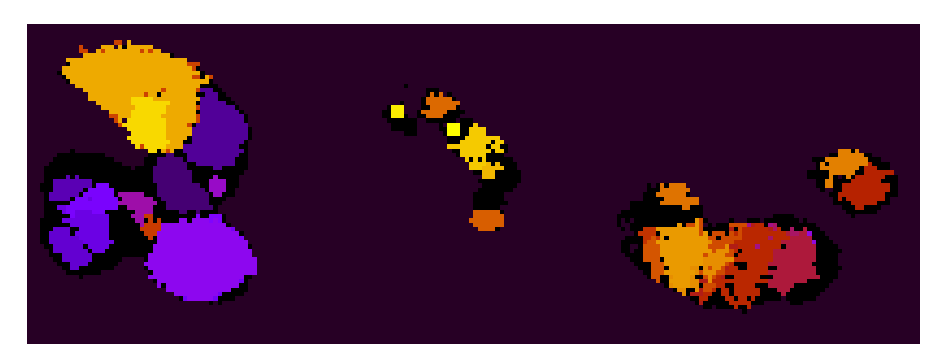

In [71]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(initial_classification,cmap='gnuplot')
ax.axis('off')
plt.show()

In [72]:
# Parameters
V = 1
thresh = 0.1
alpha = 50
unclassified_cost = 10000
grow_merge_new_ratio = [1,1000,1000]
N_rand_positions = 20

classification = Classification(R_Nx=R_Nx,R_Ny=R_Ny,
                                V=V,thresh=thresh,alpha=alpha,unclassified_cost=unclassified_cost,
                                grow_merge_new_ratio=grow_merge_new_ratio,
                                N_rand_positions=N_rand_positions,
                                braggpeak_sets_by_scan_position=braggpeak_sets_by_scan_position,
                                #classification=np.where(initial_classification!=-1,initial_classification,0))
                                classification=initial_classification)

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater


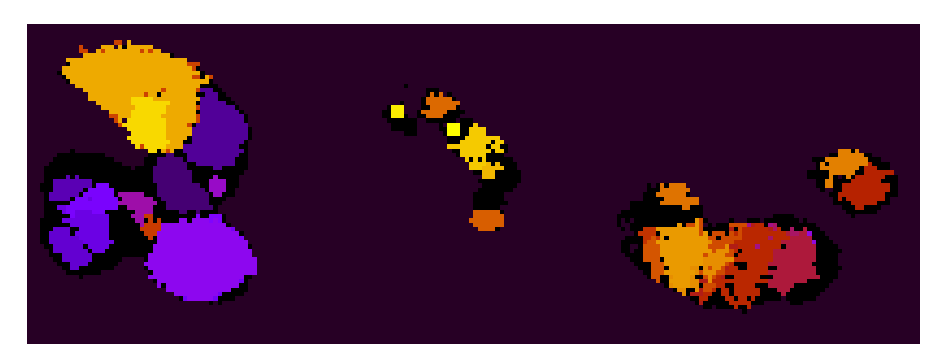

Cost = 11949226.192230877


In [73]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification_current,cmap='gnuplot')
ax.axis('off')
plt.show()

print("Cost = {}".format(classification.get_cost_current()))

In [68]:
for i in range(100):
    classification.get_new_state()

N_classes = 39
98.09533337717669
N_classes = 37
289950
N_classes = 37
29.39819857561794
N_classes = 40
56.73224374495612
N_classes = 38
-1.511256642448231
N_classes = 39
20047.77762923351
N_classes = 39
-5.4306595274323115
N_classes = 40
-0.4254948602497337


/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater


N_classes = 41
12.855679534543395
N_classes = 41
34.36679445359926
N_classes = 41
11.898645458838379
N_classes = 41
-11.061786458675243
N_classes = 42
-19.91147062739836
N_classes = 43
10000
N_classes = 43
10000
N_classes = 43
3.0377173879233696
N_classes = 43
33.9072318150323
N_classes = 43
-13.801486413774342
N_classes = 44
25.159347695847174
N_classes = 44
-69.88500690131036


AttributeError: 'NoneType' object has no attribute 'remove_data_by_scan_position'

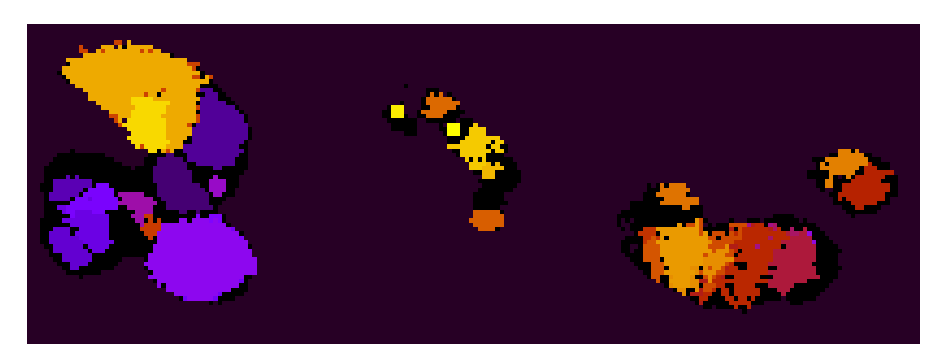

Cost = 11976457.192230877


In [693]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification_current,cmap='gnuplot')
ax.axis('off')
plt.show()

print("Cost = {}".format(classification.get_cost_current()))